In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import src

In [3]:
device = "cuda:0"
from src.models import raft

### init optical flow model
optical_flow_model = raft.get_raft_pretrained().to(device)
optical_flow_model.eval();

In [5]:
from src.datasets.datasets_common import UNNORMALIZE

In [75]:
from src.datasets.h36m import Human36M
from src.datasets.datasets_common import UNNORMALIZE
h36m_dset = Human36M(seqlen=2, set="test")

# seqlens = list(range(1, 10, 2))
seqlens = [1]

of_max_at_kps = {seqlen:[] for seqlen in seqlens}
of_mean_at_kps = {seqlen:[] for seqlen in seqlens}
of_median_at_kps = {seqlen:[] for seqlen in seqlens}

of_max_full_res = {seqlen:[] for seqlen in seqlens}
of_mean_full_res = {seqlen:[] for seqlen in seqlens}
of_median_full_res = {seqlen:[] for seqlen in seqlens}

np.random.seed(0)
for _ in tqdm(range(100)):
    idx = np.random.randint(0, len(h36m_dset))
    sample = h36m_dset[idx]    

    img_batch = UNNORMALIZE(sample['video']).clone().to(device)
    kp_2d_batch = sample['kp_2d'].clone()
    kp_2d_batch[:,:,:2] = (kp_2d_batch[:,:,:2] + 1) / 2 * 224
    for seqlen in seqlens:
        
        indices = [0,seqlen]
        img = img_batch[indices].clone()
        kp_2d = kp_2d_batch[indices].clone()
        
        mask = ( kp_2d[0,:,2] * kp_2d[-1,:,2] ) > 0.
        kp_2d = kp_2d[:,mask,:2]
        kp_2d = kp_2d.long()

        with torch.no_grad():
            # compute optical flow
            _, of_f = optical_flow_model(img[:1], img[-1:], iters=20, test_mode=True)
        of_f = of_f.cpu()

# #         fig, ax = plt.subplots(1,2,figsize=(10,5))
# #         ax[0].imshow(img_batch.cpu()[0].permute(1,2,0))
# #         ax[1].imshow(img_batch.cpu()[1].permute(1,2,0))
# #         ax[0].scatter(kp_2d_batch[0][:,0][kp_2d_batch[0][:,2] > 0.], kp_2d_batch[0][:,1][kp_2d_batch[0][:,2] > 0.])
# #         ax[1].scatter(kp_2d_batch[1][:,0][kp_2d_batch[1][:,2] > 0.], kp_2d_batch[1][:,1][kp_2d_batch[1][:,2] > 0.])

        try:
            of_masked = of_f[0, :, kp_2d[0,:,0], kp_2d[0,:,1]] # 2 x J
        except IndexError:
            continue
        of_masked_vals = of_masked.norm(dim=0)
        of_max_at_kps[seqlen].append(of_masked_vals.max().cpu().item())
        of_mean_at_kps[seqlen].append(of_masked_vals.mean().cpu().item())
        of_median_at_kps[seqlen].append(of_masked_vals.median().cpu().item())
    
# # #     ax[0].set_title(f"{of_masked.max().item():.1f}, {of_f.max().item():.1f}")
# # #     # plot OF 0 -> 1
# # #     for kp_i, (kp_x, kp_y) in enumerate(kp_2d_[:,:2][mask].cpu()):
# # #         ax[0].arrow(kp_x, kp_y, of_masked[0,kp_i], of_masked[1,kp_i], color='green')
# # #         ax[1].arrow(kp_x, kp_y, of_masked[0,kp_i], of_masked[1,kp_i], color='green')

# # #     cx, cy = 115, 80
# # #     width = 100
# # #     for axis in ax: 
# # #         axis.set_xlim((cx-width/2,cx+width/2))
# # #         axis.set_ylim((cy+width/2,cy-width/2))

Human36M Dataset overlap ratio:  0.0
Loaded h36m dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/h36m/h36m_test_25fps_db.pt
h36m - number of dataset objects 54386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]


In [76]:
from src.datasets.threedpw import ThreeDPW
threedpw_dset = ThreeDPW(seqlen=2, set="test")

of_max_at_kps_3dpw = []
of_mean_at_kps_3dpw = []
of_median_at_kps_3dpw = []

np.random.seed(0)
for _ in tqdm(range(100)):
    idx = np.random.randint(0, len(threedpw_dset))
    sample = threedpw_dset[idx]    

    img_batch = UNNORMALIZE(sample['video']).clone().to(device)
    kp_2d_batch = sample['kp_2d'].clone()
    kp_2d_batch[:,:,:2] = (kp_2d_batch[:,:,:2] + 1) / 2 * 224

    indices = [0,1]
    img = img_batch[indices].clone()
    kp_2d = kp_2d_batch[indices].clone()
    mask = ( kp_2d[0,:,2] * kp_2d[-1,:,2] ) > 0.
    kp_2d = kp_2d[:,mask,:2].long()

    with torch.no_grad():
        # compute optical flow
        _, of_f = optical_flow_model(img[:1], img[-1:], iters=20, test_mode=True)
    of_f = of_f.cpu()
    
    mask_add = (kp_2d[0,:,0] < 224) * (kp_2d[0,:,1] < 224)
    of_masked = of_f[0, :, kp_2d[0,:,0][mask_add], kp_2d[0,:,1][mask_add]] # 2 x J
    of_masked_vals = of_masked.norm(dim=0)
    of_max_at_kps_3dpw.append(of_masked_vals.max().cpu().item())
    of_mean_at_kps_3dpw.append(of_masked_vals.mean().cpu().item())
    of_median_at_kps_3dpw.append(of_masked_vals.median().cpu().item())

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 17273


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.27it/s]


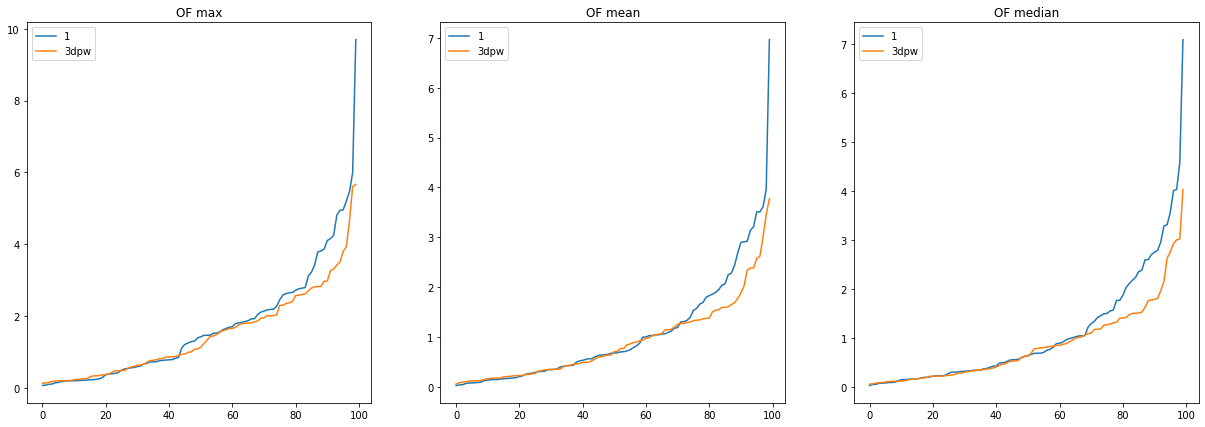

In [78]:
fig, ax = plt.subplots(1,3,figsize=(7*3, 7))
colors = ['blue', 'darkorange', 'green', 'red', 'purple', 'violet', 'majenta']
# for j, (dset, dset_name) in enumerate(zip(dsets, ["h36m", "3dpw"])):
for i, seqlen in enumerate(seqlens):
    ax[0].plot(sorted(of_max_at_kps[seqlen]), label=seqlen)
    ax[1].plot(sorted(of_mean_at_kps[seqlen]), label=seqlen)
    ax[2].plot(sorted(of_median_at_kps[seqlen]), label=seqlen)

    ax[0].set_title(f"OF max")
    ax[1].set_title(f"OF mean")
    ax[2].set_title(f"OF median")
    
ax[0].plot(sorted(of_max_at_kps_3dpw), label="3dpw")
ax[1].plot(sorted(of_mean_at_kps_3dpw), label="3dpw")
ax[2].plot(sorted(of_median_at_kps_3dpw), label="3dpw")

for axis in ax.flatten(): axis.legend()

In [30]:
from src.datasets.threedpw import ThreeDPW
threedpw_dset = ThreeDPW(seqlen=20, set="test")

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 1712


In [32]:
seqlens = list(range(1, 10, 2))

dsets = [h36m_dset, threedpw_dset]
dset_names = ["h36m", "3dpw"]
of_max_at_kps = {dset : {seqlen:[] for seqlen in seqlens} for dset in dset_names}
of_mean_at_kps = {dset : {seqlen:[] for seqlen in seqlens} for dset in dset_names}
of_median_at_kps = {dset : {seqlen:[] for seqlen in seqlens} for dset in dset_names}

of_max_full_res = {dset : {seqlen:[] for seqlen in seqlens} for dset in dset_names}
of_mean_full_res = {dset : {seqlen:[] for seqlen in seqlens} for dset in dset_names}
of_median_full_res = {dset : {seqlen:[] for seqlen in seqlens} for dset in dset_names}

for dset, dset_name in zip(dsets, dset_names):
    np.random.seed(0)
    for _ in tqdm(range(100)):
        idx = np.random.randint(0, len(dset))

        sample = dset[idx]    

        img_batch = UNNORMALIZE(sample['video']).clone().to(device)
        kp_2d_batch = sample['kp_2d'].clone()
        kp_2d_batch[:,:,:2] = (kp_2d_batch[:,:,:2] + 1) / 2 * 224

        # select particular samples in the batch
        for seqlen in seqlens:

            indices = [0,seqlen]
            img = img_batch[indices]
            kp_2d = kp_2d_batch[indices]

            # optical flow from 0 to 1
            with torch.no_grad():
                # compute optical flow
                _, of_f = optical_flow_model(img[:1], img[-1:], iters=20, test_mode=True)
    #         of_f = of_f.cpu()

            kps_mask = (kp_2d_[:,:2][mask]).long()
            of_masked = of_f[0, :, kps_mask[:,0], kps_mask[:,1]] # 2 x J

            of_vals = of_f[0].norm(dim=0)
            of_masked_vals = of_masked.norm(dim=0)

            of_max_at_kps[dset_name][seqlen].append(of_masked_vals.max().cpu().item())
            of_max_full_res[dset_name][seqlen].append(of_vals.max().cpu().item())

            of_mean_at_kps[dset_name][seqlen].append(of_masked_vals.mean().cpu().item())
            of_mean_full_res[dset_name][seqlen].append(of_vals.mean().cpu().item())

            of_median_at_kps[dset_name][seqlen].append(of_masked_vals.median().cpu().item())
            of_median_full_res[dset_name][seqlen].append(of_vals.median().cpu().item())
    
#     ax[0].set_title(f"{of_masked.max().item():.1f}, {of_f.max().item():.1f}")
#     # plot OF 0 -> 1
#     for kp_i, (kp_x, kp_y) in enumerate(kp_2d_[:,:2][mask].cpu()):
#         ax[0].arrow(kp_x, kp_y, of_masked[0,kp_i], of_masked[1,kp_i], color='green')
#         ax[1].arrow(kp_x, kp_y, of_masked[0,kp_i], of_masked[1,kp_i], color='green')

#     cx, cy = 115, 80
#     width = 100
#     for axis in ax: 
#         axis.set_xlim((cx-width/2,cx+width/2))
#         axis.set_ylim((cy+width/2,cy-width/2))

  0%|                                                                                                                                                     | 0/100 [00:01<?, ?it/s]


NameError: name 'kp_2d_' is not defined

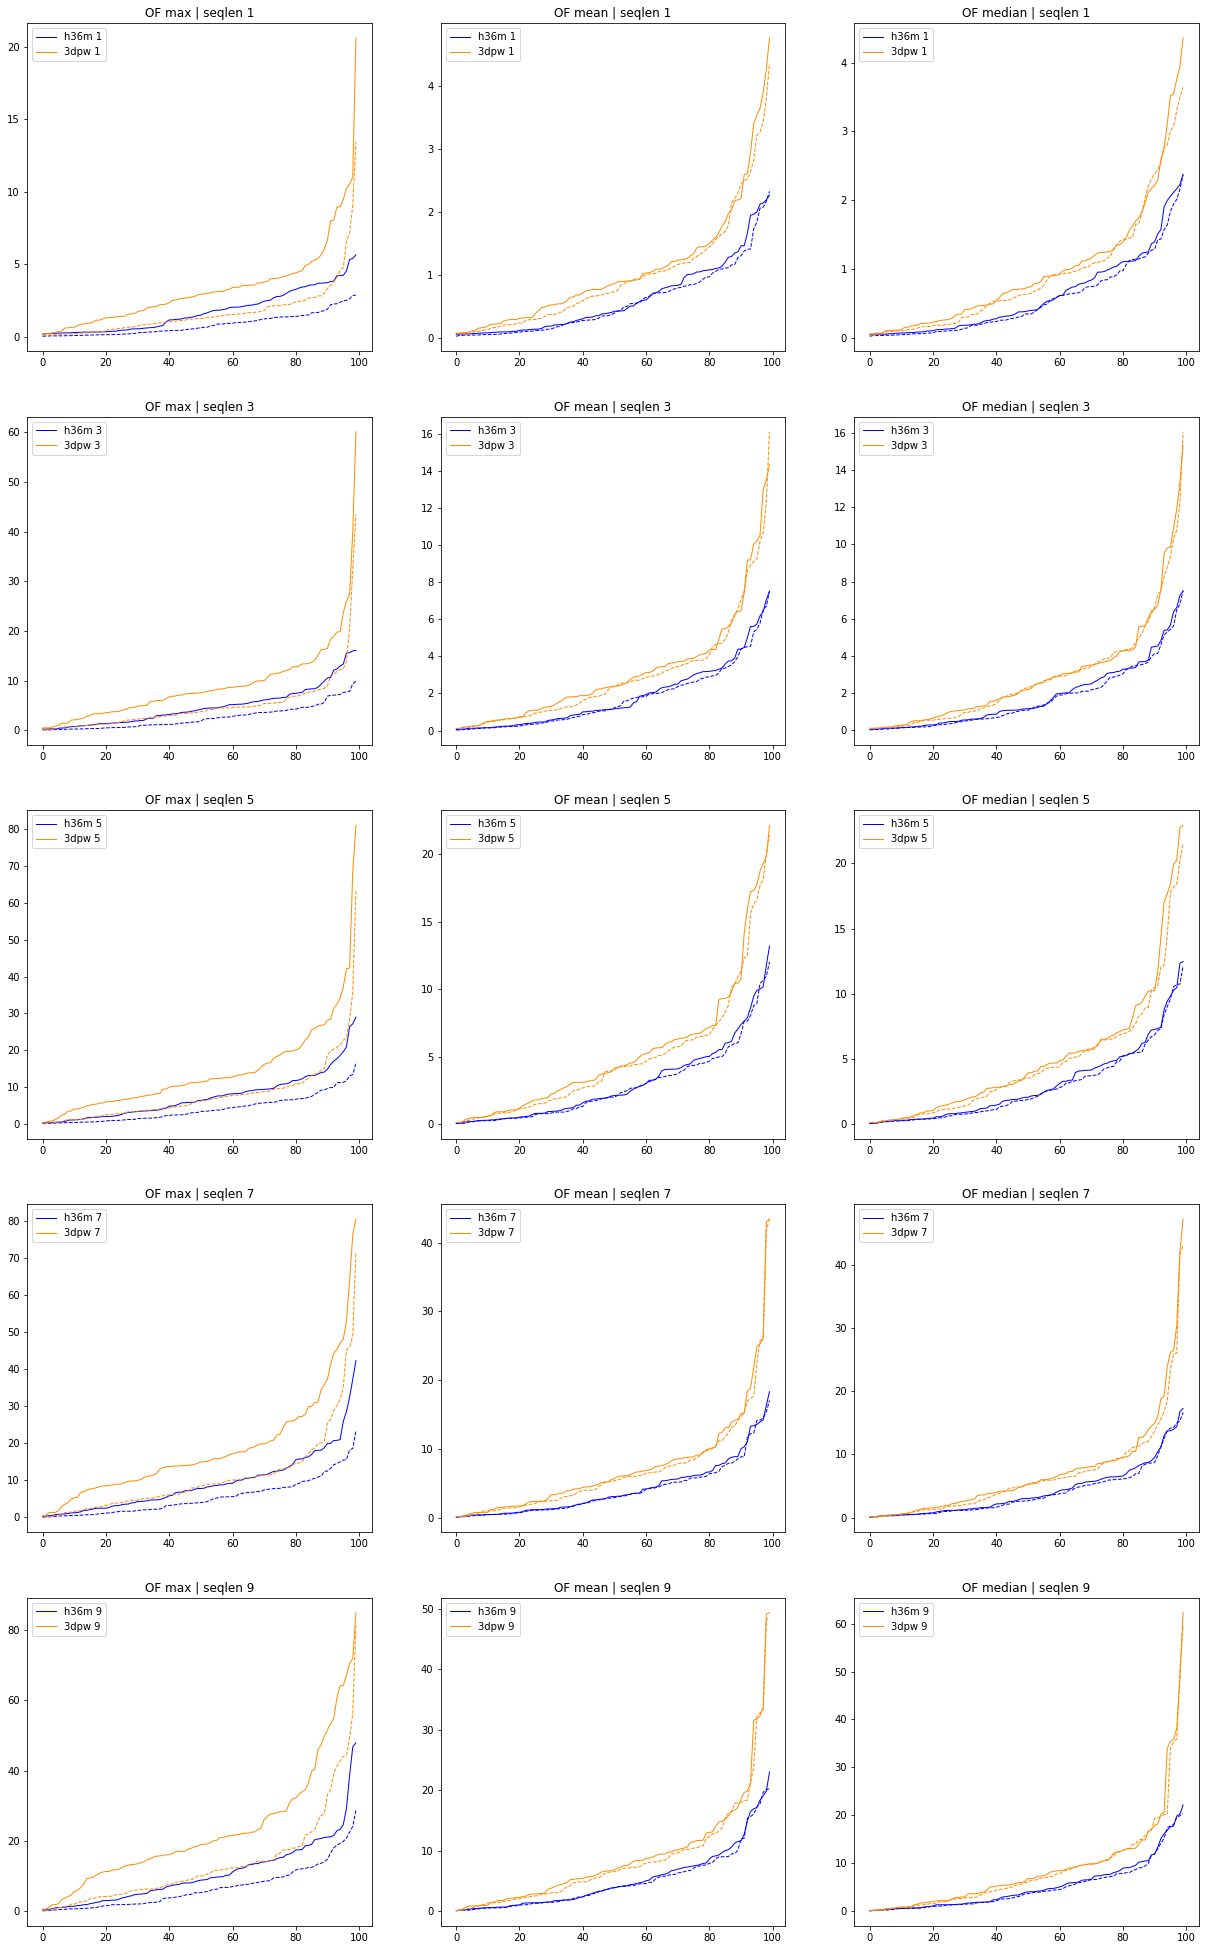

In [228]:
fig, ax = plt.subplots(len(seqlens),3,figsize=(7*3, 7*len(seqlens)))
colors = ['blue', 'darkorange', 'green', 'red', 'purple', 'violet', 'majenta']
for j, (dset, dset_name) in enumerate(zip(dsets, ["h36m", "3dpw"])):
    for i, seqlen in enumerate(seqlens):
        ax[i, 0].plot(sorted(of_max_full_res[dset_name][seqlen]), label=f"{dset_name} {seqlen}", c=colors[j], linewidth=1)
        ax[i, 1].plot(sorted(of_mean_full_res[dset_name][seqlen]), label=f"{dset_name} {seqlen}", c=colors[j], linewidth=1)
        ax[i, 2].plot(sorted(of_median_full_res[dset_name][seqlen]), label=f"{dset_name} {seqlen}", c=colors[j], linewidth=1)

        ax[i, 0].plot(sorted(of_max_at_kps[dset_name][seqlen]), c=colors[j], linewidth=1, linestyle="--")
        ax[i, 1].plot(sorted(of_mean_at_kps[dset_name][seqlen]), c=colors[j], linewidth=1, linestyle="--")
        ax[i, 2].plot(sorted(of_median_at_kps[dset_name][seqlen]), c=colors[j], linewidth=1, linestyle="--")
        
        ax[i, 0].set_title(f"OF max | seqlen {seqlen}")
        ax[i, 1].set_title(f"OF mean | seqlen {seqlen}")
        ax[i, 2].set_title(f"OF median | seqlen {seqlen}")
for axis in ax.flatten(): axis.legend()

# check OF of 3DPW

In [76]:
from src.datasets.threedpw import ThreeDPW
threedpw_dset = ThreeDPW(seqlen=20, set="test", use_OFformat=True)
idx = 10 # 3400
idx = 1100
sample = threedpw_dset[idx]    
seqlen = 9

# from src.datasets.h36m import Human36M
# h36m_dset = Human36M(seqlen=20, set="test", color_distort=True, use_OFformat=True)
# idx = 5344
# sample = h36m_dset[idx]    
# seqlen = 8

# from src.datasets.pennaction import PennAction
# pa_dset = PennAction(seqlen=20, use_OFformat=True)
# idx = 10
# sample = pa_dset[idx]    
# seqlen = 1



img_LR = UNNORMALIZE(sample['video']).clone()
img_HR = UNNORMALIZE(sample['videoOF']).clone()
kp_2d = sample['kp_2d'].clone()
kp_2d[:,:,:2] = (kp_2d[:,:,:2] + 1) / 2 # from 0 to 1

# take pairs of images
indices = [0,seqlen]
img_LR = img_LR[indices]
img_HR = img_HR[indices]
kp_2d = kp_2d[indices]
bbox = sample['bbox'][indices]

imgs_mix = []
kps_vis = []
ofs_masked = []
ofs_normed = []

for img in [img_LR, img_HR]:
    
#     fig, ax = plt.subplots(1,len(img)+1,figsize=(7,7))
    img1 = img.permute(0,2,3,1)[0]
    img2 = img.permute(0,2,3,1)[1]
    img_mix = img1 / 255 / 2 + img2 / 255 / 2
    imgs_mix.append(img_mix)
#     ax[0].imshow(img_mix)    
    res = img.size(-1)

    # plot kps of 0
    kp_2d_ = kp_2d[0].clone()
    kp_2d_[:,:2] = kp_2d_[:,:2] * res
    mask = kp_2d_[:,2] > 0.
    kps_vis.append(kp_2d_[mask])
#     ax[0].scatter(kp_2d_[:,0][mask], kp_2d_[:,1][mask], s=10, c="red")

    # optical flow from 0 to 1
    with torch.no_grad():
        # compute optical flow
        _, of_f = optical_flow_model(img[:1].to(device), img[-1:].to(device), iters=20, test_mode=True)
    of_f = of_f.cpu()
    
    kps_mask = (kp_2d_[:,:2][mask]).long()
    of_masked = of_f[0, :, kps_mask[:,0], kps_mask[:,1]] # 2 x J
    ofs_masked.append(of_masked)
    
#     ax[0].set_title(f"{of_masked.norm(dim=0).max().item():.1f}, {of_f[0].norm(dim=0).max().item():.1f}")
    # plot OF 0 -> 1
#     for kp_i, (kp_x, kp_y) in enumerate(kp_2d_[:,:2][mask].cpu()):
#         ax[0].arrow(kp_x, kp_y, of_masked[0,kp_i], of_masked[1,kp_i], color='green', width=1)
    
#     ### centered square crop
#     cx, cy = 0.5, 0.5
#     width = 0.5
#     t,b,l,r = (cy-width/2) * res,  (cy+width/2) * res, (cx-width/2) * res, (cx+width/2) * res
    
    ### centered rect crop
    cx, cy = 0.5, 0.5
    width, height = 0.45, 1.
    t,b,l,r = (cy-height/2) * res,  (cy+height/2) * res, (cx-width/2) * res, (cx+width/2) * res
    
#     ax[0].set_xlim((l,r))
#     ax[0].set_ylim((b,t))
    ofs_normed.append(of_f[0].norm(dim=0))
#     ax[1].imshow(of_f[0].norm(dim=0)[int(t):int(b),int(l):int(r)])
    
#     for axis in ax: axis.set_axis_off()
#     fig.subplots_adjust(wspace=0)
#     fig.tight_layout()
    

    

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 1712


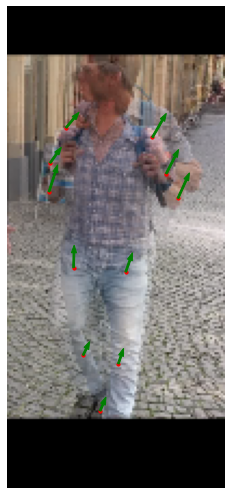

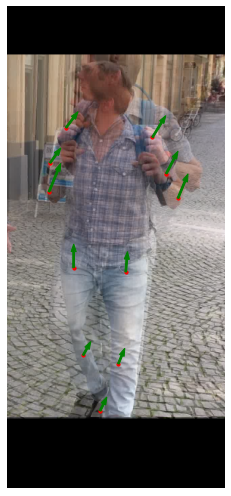

In [77]:
cx, cy = 0.5, 0.5
width, height = 0.45, 1.

res = 224
res_idx = 0
t,b,l,r = (cy-height/2) * res,  (cy+height/2) * res, (cx-width/2) * res, (cx+width/2) * res
fig, ax = plt.subplots(1,1,figsize=(7,7))
# img
ax.imshow(imgs_mix[res_idx])
# kpts
ax.scatter(kps_vis[res_idx][:,0], kps_vis[res_idx][:,1], s=10, c="red")
# of flow
for kp_i, (kp_x, kp_y) in enumerate(kps_vis[res_idx][:,:2]):
    ax.arrow(
        kp_x, kp_y, 
        ofs_masked[res_idx][0,kp_i], ofs_masked[res_idx][1,kp_i], 
        color='green', width=0.8*res/224, length_includes_head=True)

ax.set_xlim((l,r))
ax.set_ylim((b,t))

ax.set_axis_off()
fig.tight_layout()
fig.savefig(f"./../paper_sub/OF_diff_resolutions/_imgLR.pdf", format="pdf", pad_inches=0., bbox_inches="tight")




res = 640
res_idx = 1
t,b,l,r = (cy-height/2) * res,  (cy+height/2) * res, (cx-width/2) * res, (cx+width/2) * res
fig, ax = plt.subplots(1,1,figsize=(7,7))
# img
ax.imshow(imgs_mix[res_idx])
# kpts
ax.scatter(kps_vis[res_idx][:,0], kps_vis[res_idx][:,1], s=10, c="red")
# of flow
for kp_i, (kp_x, kp_y) in enumerate(kps_vis[res_idx][:,:2]):
    ax.arrow(
        kp_x, kp_y, 
        ofs_masked[res_idx][0,kp_i], ofs_masked[res_idx][1,kp_i], 
        color='green', width=0.8*res/224, length_includes_head=True)

ax.set_xlim((l,r))
ax.set_ylim((b,t))

ax.set_axis_off()
fig.tight_layout()
fig.savefig(f"./../paper_sub/OF_diff_resolutions/_imgHR.pdf", format="pdf", pad_inches=0., bbox_inches="tight")

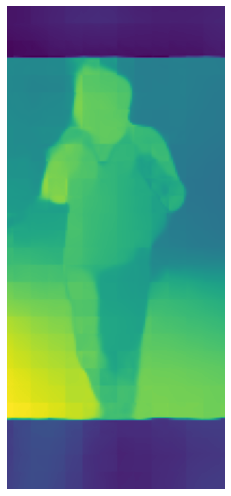

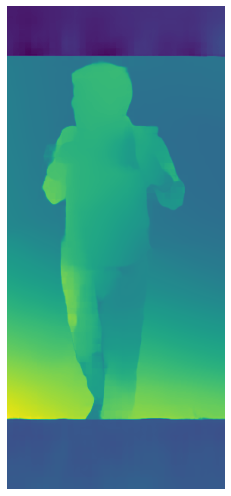

In [78]:
cx, cy = 0.5, 0.5
width, height = 0.45, 1.

res = 224
res_idx = 0
t,b,l,r = (cy-height/2) * res,  (cy+height/2) * res, (cx-width/2) * res, (cx+width/2) * res
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(ofs_normed[res_idx][int(t):int(b),int(l):int(r)])
ax.set_axis_off()
fig.tight_layout()
fig.savefig(f"./../paper_sub/OF_diff_resolutions/_ofLR.pdf", format="pdf", pad_inches=0., bbox_inches="tight")


res = 640
res_idx = 1
t,b,l,r = (cy-height/2) * res,  (cy+height/2) * res, (cx-width/2) * res, (cx+width/2) * res
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(ofs_normed[res_idx][int(t):int(b),int(l):int(r)])
ax.set_axis_off()
fig.tight_layout()
fig.savefig(f"./../paper_sub/OF_diff_resolutions/_ofHR.pdf", format="pdf", pad_inches=0., bbox_inches="tight")


In [26]:
# from matplotlib.backends.backend_agg import FigureCanvasAgg
# from matplotlib.figure import Figure
# import numpy as np

# # make a Figure and attach it to a canvas.
# fig = Figure(figsize=(5, 4), dpi=100)
# canvas = FigureCanvasAgg(fig)

# # Do some plotting here
# ax = fig.add_subplot(111)
# ax.plot([1, 2, 3])

# # Retrieve a view on the renderer buffer
# canvas.draw()
# buf = canvas.buffer_rgba()
# # convert to a NumPy array
# X = np.asarray(buf)

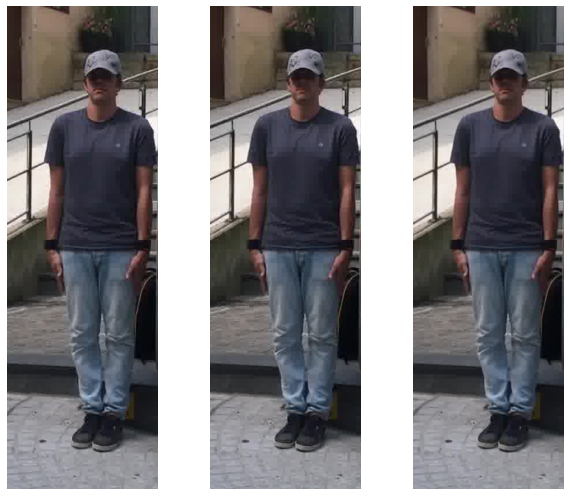

In [7]:
fig, ax = plt.subplots(1,len(img)+1,figsize=(3*(len(img)+1),7))
ax[0].imshow(img.permute(0,2,3,1)[0][:,200:400])
ax[1].imshow(img.permute(0,2,3,1)[1][:,200:400])
ax[2].imshow((img.permute(0,2,3,1)[0]/255 / 2 + img.permute(0,2,3,1)[1]/255 / 2) [:,200:400])
for axis in ax: axis.set_axis_off()
fig.tight_layout()
fig.subplots_adjust()